In [1]:
# Recommender system part of the code

In [2]:
# Importing all libraries needed to run the rest of the script
import numpy as np
import pandas as pd
import sklearn
import networkx as nx
import matplotlib.pyplot as plt
import math as math
import time
import seaborn as sns
import re
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from nltk.stem import WordNetLemmatizer
from scipy.stats import pearsonr
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [14,14]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dinko\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\dinko\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dinko\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Reading the netflix data set file and importing it to the netflix_dataset
netflix_dataset = pd.read_csv('./netflix_titles.csv')
netflix_dataset.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [4]:
# Counting all non-null values in the netflix_dataset
netflix_dataset.groupby('type').count()

,show_id,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
type,,,,,,,,,,,
Movie,6131,6131,5943,5656,5691,6131,6131,6129,6128,6131,6131
TV Show,2676,2676,230,2326,2285,2666,2676,2674,2676,2676,2676


In [5]:
# Getting more information regarding the netflix_dataset
netflix_dataset.describe(include=["object", "bool"])

,show_id,type,title,director,cast,country,date_added,rating,duration,listed_in,description
count,8807,8807,8807,6173,7982,7976,8797,8803,8804,8807,8807
unique,8807,2,8807,4528,7692,748,1767,17,220,514,8775
top,s1,Movie,Dick Johnson Is Dead,Rajiv Chilaka,David Attenborough,United States,"January 1, 2020",TV-MA,1 Season,"Dramas, International Movies","Paranormal activity at a lush, abandoned prope..."
freq,1,6131,1,19,19,2818,109,3207,1793,362,4


In [6]:
# Extracting the data regarding movies from the netflix_dataset into the movies data set
movies = netflix_dataset[netflix_dataset['type'] == 'Movie'].reset_index()
movies.head()

,index,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,6,s7,Movie,My Little Pony: A New Generation,"Robert Cullen, José Luis Ucha","Vanessa Hudgens, Kimiko Glenn, James Marsden, ...",NaN,"September 24, 2021",2021,PG,91 min,Children & Family Movies,Equestria's divided. But a bright-eyed hero be...
2,7,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...","September 24, 2021",1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies","On a photo shoot in Ghana, an American model s..."
3,9,s10,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,"September 24, 2021",2021,PG-13,104 min,"Comedies, Dramas",A woman adjusting to life after a loss contend...
4,12,s13,Movie,Je Suis Karl,Christian Schwochow,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ...","Germany, Czech Republic","September 23, 2021",2021,TV-MA,127 min,"Dramas, International Movies",After most of her family is murdered in a terr...


In [7]:
# Extracting the data regarding tv shows from the netflix_dataset into the tv_shows data set
tv_shows = netflix_dataset[netflix_dataset['type'] == 'TV Show'].reset_index()
tv_shows.head()

,index,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
1,2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
2,3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
3,4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...
4,5,s6,TV Show,Midnight Mass,Mike Flanagan,"Kate Siegel, Zach Gilford, Hamish Linklater, H...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries",The arrival of a charismatic young priest brin...


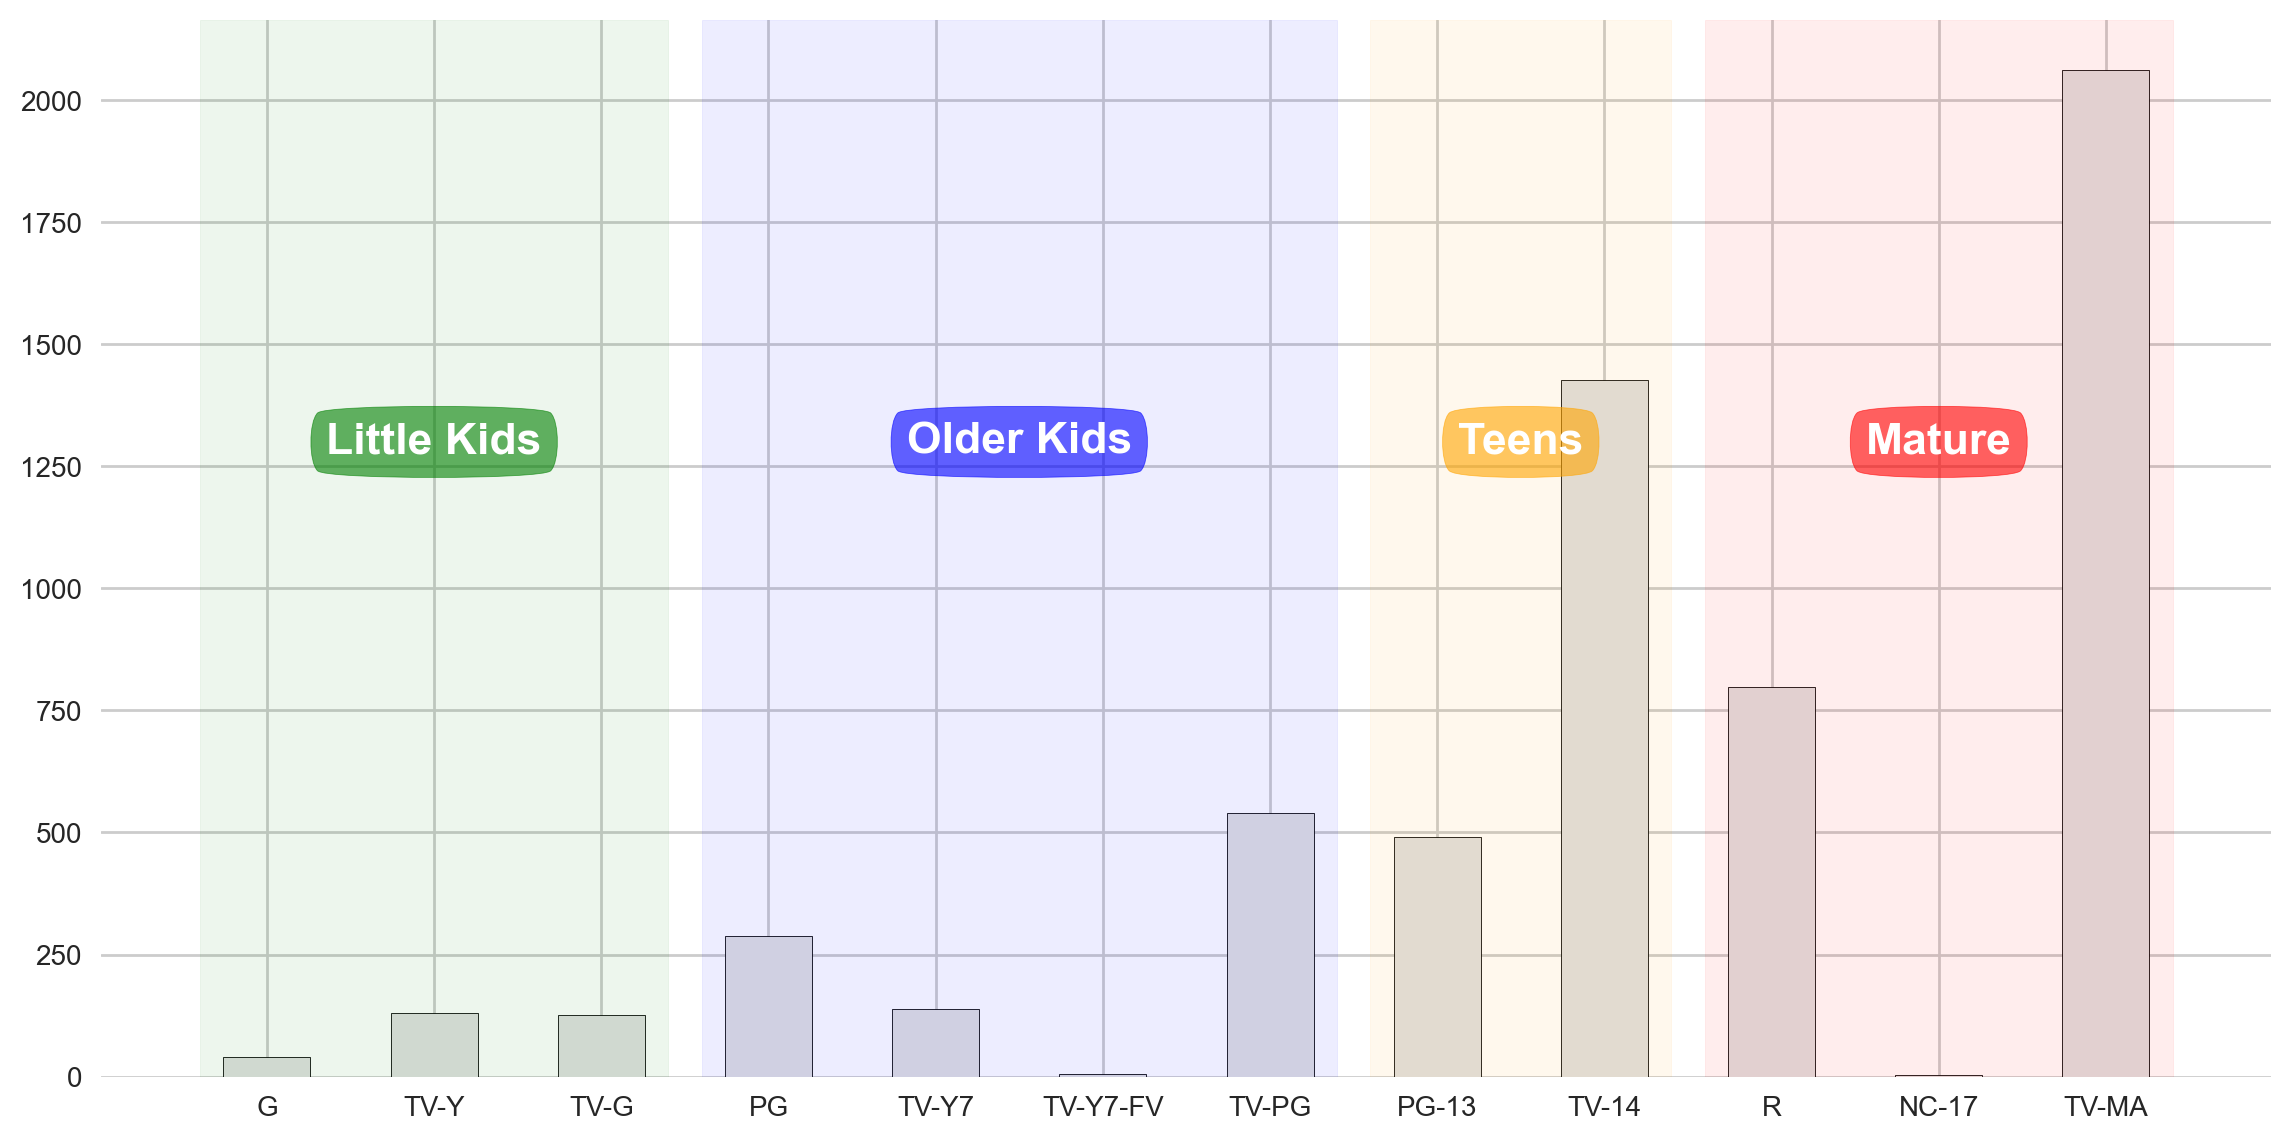

In [8]:
# Plotting the data from movies ratings and grouping it according to the age categories
sns.set_style('whitegrid')

uniqueRating = movies['rating'].unique()
movie_rating_order_according_to_age_categories =  ['G', 'TV-Y', 'TV-G', 'PG', 'TV-Y7', 'TV-Y7-FV', 'TV-PG', 'PG-13', 'TV-14', 'R', 'NC-17', 'TV-MA']
tv_show_rating_order_according_to_age_categories =  ['TV-Y', 'TV-G', 'TV-Y7', 'TV-Y7-FV', 'TV-PG', 'TV-14', 'R', 'TV-MA']

movie_ratings = movies['rating'].value_counts()[movie_rating_order_according_to_age_categories]
tv_show_ratings = tv_shows['rating'].value_counts()[tv_show_rating_order_according_to_age_categories]


def plot_ratings_bar_for_movies(data, title, height, h_lim=None):
    fig, ax = plt.subplots(1,1, figsize=(14, 7), dpi=200)
    if h_lim :
        ax.set_ylim(0, h_lim)
    ax.bar(data.index, data,  color="#e0e0e0", width=0.52, edgecolor='black')

    color =  ['green',  'blue',  'orange',  'red']
    span_range = [[0, 2], [3,  6], [7, 8], [9, 11]]

    for idx, sub_title in enumerate(['Little Kids', 'Older Kids', 'Teens', 'Mature']):
        ax.annotate(sub_title,
                    xy=(sum(span_range[idx])/2 ,height),
                    xytext=(0,0), textcoords='offset points',
                    va="center", ha="center",
                    color="w", fontsize=16, fontweight='bold',
                    bbox=dict(boxstyle='round4', pad=0.4, color=color[idx], alpha=0.6))
        ax.axvspan(span_range[idx][0]-0.4,span_range[idx][1]+0.4,  color=color[idx], alpha=0.07)
    plt.show()
    
plot_ratings_bar_for_movies(movie_ratings,'Movie', 1300)

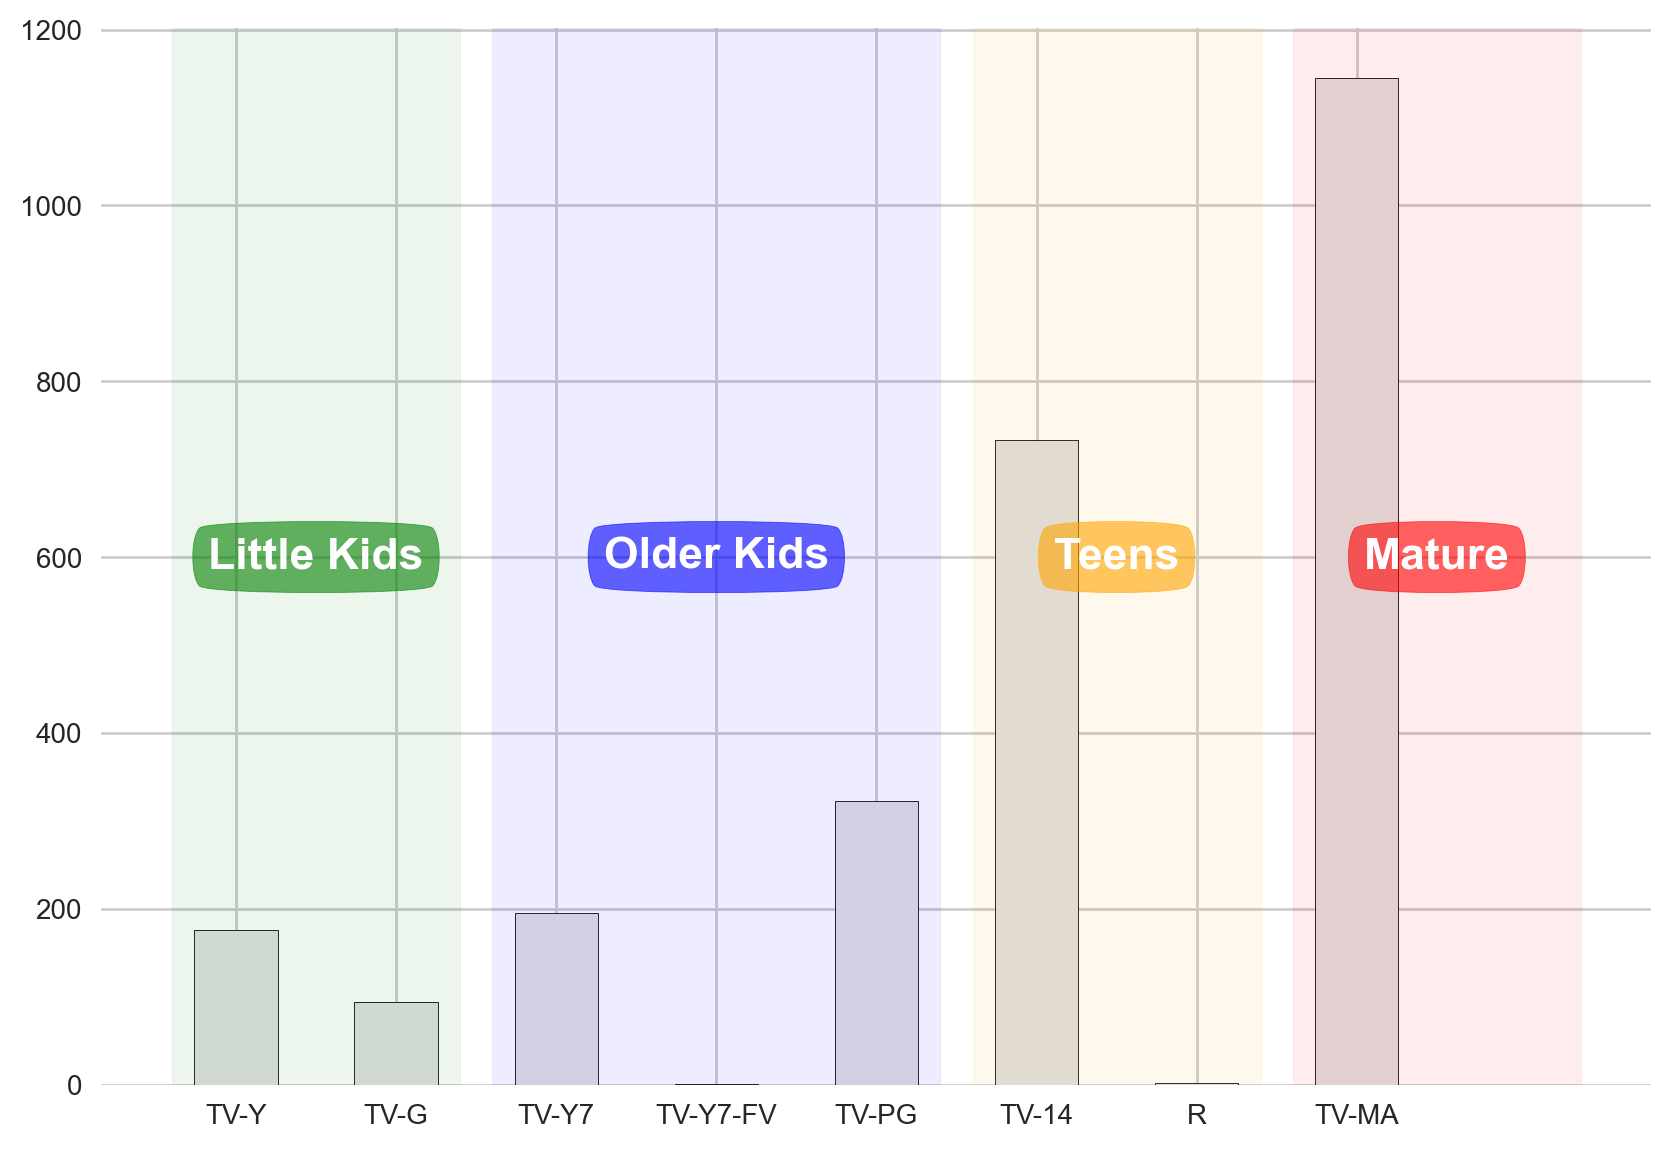

In [9]:
# Plotting the data from tv shows ratings and grouping it according to the age categories
def plot_ratings_bar_for_tv_shows(data, title, height, h_lim=None):
    fig, ax = plt.subplots(1,1, figsize=(10, 7), dpi=200)
    if h_lim :
        ax.set_ylim(0, h_lim)
    ax.bar(data.index, data,  color="#e0e0e0", width=0.52, edgecolor='black')

    color =  ['green',  'blue',  'orange',  'red']
    span_range = [[0, 1], [2,  4], [5, 6], [7, 8]]

    for idx, sub_title in enumerate(['Little Kids', 'Older Kids', 'Teens', 'Mature']):
        ax.annotate(sub_title,
                    xy=(sum(span_range[idx])/2 ,height),
                    xytext=(0,0), textcoords='offset points',
                    va="center", ha="center",
                    color="w", fontsize=16, fontweight='bold',
                    bbox=dict(boxstyle='round4', pad=0.4, color=color[idx], alpha=0.6))
        ax.axvspan(span_range[idx][0]-0.4,span_range[idx][1]+0.4,  color=color[idx], alpha=0.07)
    plt.show()


plot_ratings_bar_for_tv_shows(tv_show_ratings,'TV Show', 600)

In [10]:
# Function for plotting a heatmap to present the relationship of the genres
def genre_relationship_heatmap(dataframe, title):
    print(f"{title} genre heatmap")    
    dataframe['genre'] = dataframe['listed_in'].apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(',')) 
    genres_from_dataset = dataframe['genre']
    mlb = MultiLabelBinarizer()
    res = pd.DataFrame(mlb.fit_transform(genres_from_dataset), columns=mlb.classes_, index=genres_from_dataset.index)
    corr = res.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(16, 15))
    pl = sns.heatmap(corr, mask=mask, cmap= "coolwarm", vmax=.6, vmin=-.6, center=0, square=True, linewidths=.6, cbar_kws={"shrink": 0.8})
    
    plt.show()

TV Show genre heatmap


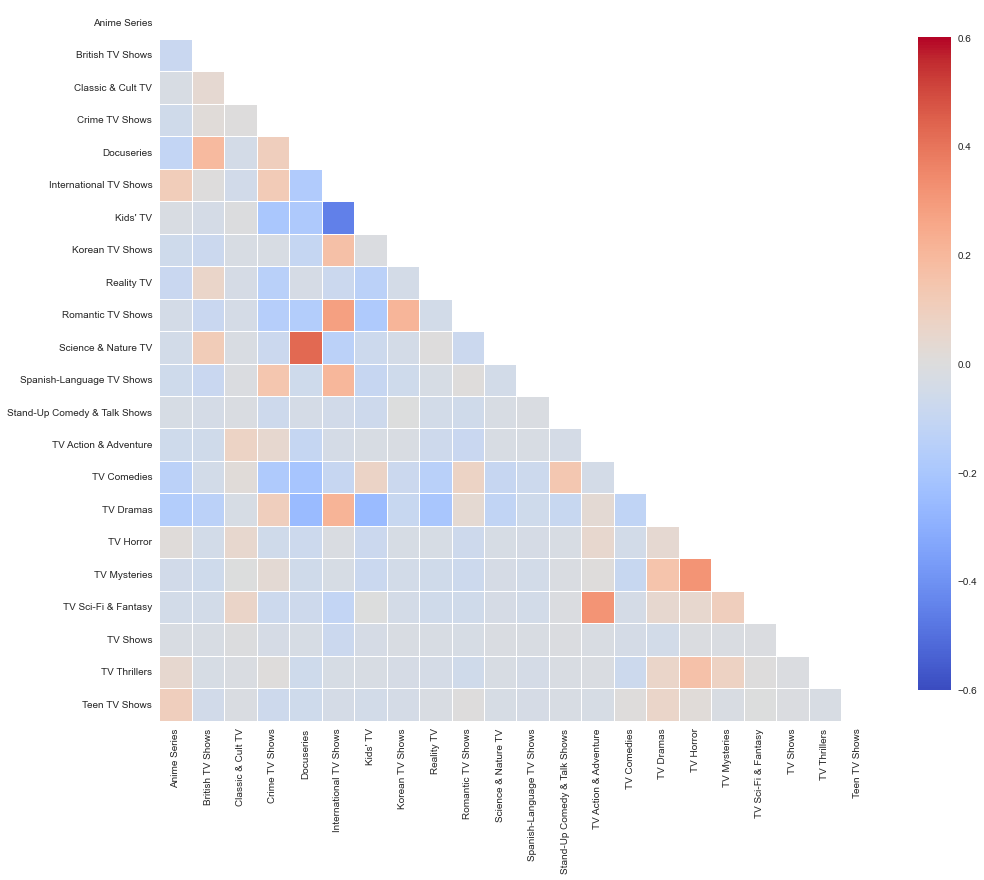

In [11]:
# Plotting the genre relationship heatmap for tv shows
genre_relationship_heatmap(tv_shows, 'TV Show')

Movie genre heatmap


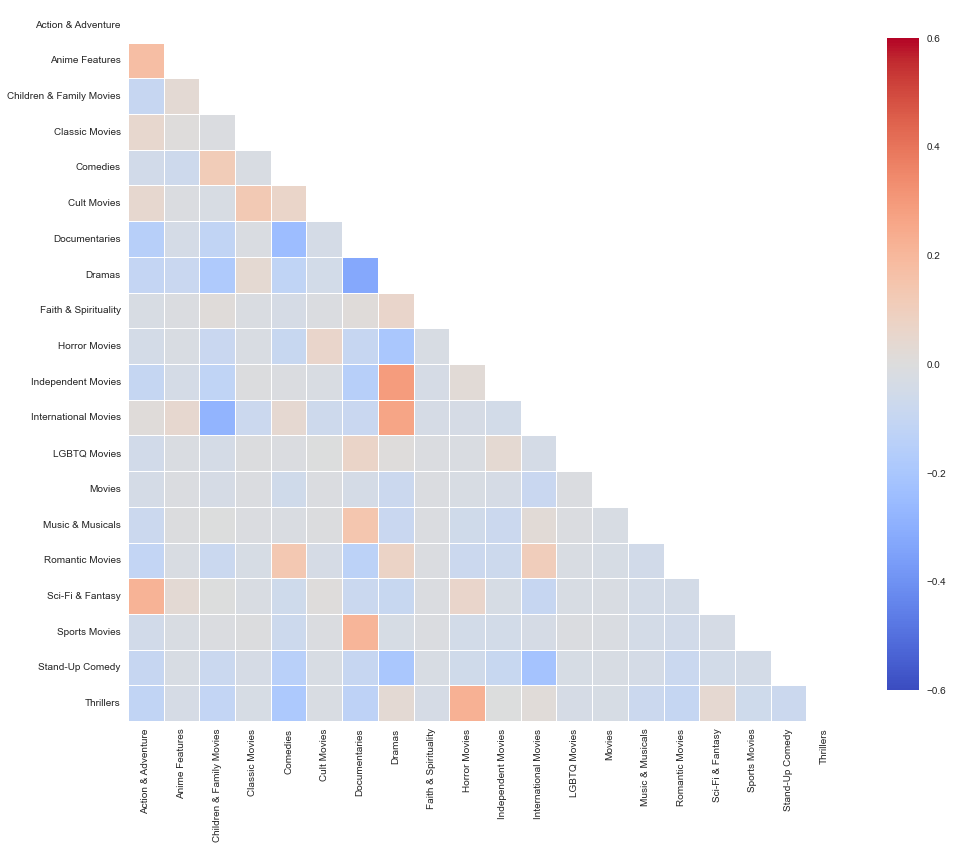

In [12]:
# Plotting the genre relationship heatmap for movies
genre_relationship_heatmap(movies, 'Movie')

In [13]:
# Checking how many null values are present in each column
netflix_dataset.isna().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

In [14]:
# Dropping rows which contain null values in column 'cast', 'country' and 'rating'
netflix_dataset = netflix_dataset.dropna(subset=['cast', 'country', 'rating'])
# Filling null values in the 'director' column with 'Unknown' in the netflix_dataset 
netflix_dataset['director'].fillna('Unkown', inplace = True)
netflix_dataset.reset_index()
netflix_dataset.isna().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      9
release_year    0
rating          0
duration        3
listed_in       0
description     0
dtype: int64

In [15]:
# Extracting the data regarding movies from the netflix_dataset into the movies data set
movies = netflix_dataset[netflix_dataset['type'] == 'Movie'].reset_index()
movies = movies.drop(['index', 'release_year', 'duration', 'date_added'], axis=1)
movies.head()

,show_id,type,title,director,cast,country,rating,listed_in,description
0,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...",TV-MA,"Dramas, Independent Movies, International Movies","On a photo shoot in Ghana, an American model s..."
1,s10,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,PG-13,"Comedies, Dramas",A woman adjusting to life after a loss contend...
2,s13,Movie,Je Suis Karl,Christian Schwochow,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ...","Germany, Czech Republic",TV-MA,"Dramas, International Movies",After most of her family is murdered in a terr...
3,s25,Movie,Jeans,S. Shankar,"Prashanth, Aishwarya Rai Bachchan, Sri Lakshmi...",India,TV-14,"Comedies, International Movies, Romantic Movies",When the father of the man she loves insists t...
4,s28,Movie,Grown Ups,Dennis Dugan,"Adam Sandler, Kevin James, Chris Rock, David S...",United States,PG-13,Comedies,Mourning the loss of their beloved junior high...


In [16]:
# Extracting the data regarding tv shows from the netflix_dataset into the tv shows data set
tv_shows = netflix_dataset[netflix_dataset['type'] == 'TV Show'].reset_index()
tv_shows = tv_shows.drop(['index', 'release_year', 'duration', 'date_added'], axis=1)
tv_shows.head()

,show_id,type,title,director,cast,country,rating,listed_in,description
0,s2,TV Show,Blood & Water,Unkown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,TV-MA,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
1,s5,TV Show,Kota Factory,Unkown,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,TV-MA,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...
2,s9,TV Show,The Great British Baking Show,Andy Devonshire,"Mel Giedroyc, Sue Perkins, Mary Berry, Paul Ho...",United Kingdom,TV-14,"British TV Shows, Reality TV",A talented batch of amateur bakers face off in...
3,s16,TV Show,Dear White People,Unkown,"Logan Browning, Brandon P. Bell, DeRon Horton,...",United States,TV-MA,"TV Comedies, TV Dramas",Students of color navigate the daily slights a...
4,s18,TV Show,Falsa identidad,Unkown,"Luis Ernesto Franco, Camila Sodi, Sergio Goyri...",Mexico,TV-MA,"Crime TV Shows, Spanish-Language TV Shows, TV ...",Strangers Diego and Isabel flee their home in ...


In [17]:
# Initializing the stopwords_list and inserting English stopwords
stopwords_list = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [18]:
# Initializing the TF-IDF vertorizer
vectorizer = TfidfVectorizer(analyzer='word')

In [19]:
# Creating the 'all_content' column in movies dataset
movies['all_content'] = movies['director'] + movies['cast'] + movies['country'] + movies['rating'] + movies['listed_in']
movies['all_content']

0       Haile GerimaKofi Ghanaba, Oyafunmike Ogunlano,...
1       Theodore MelfiMelissa McCarthy, Chris O'Dowd, ...
2       Christian SchwochowLuna Wedler, Jannis Niewöhn...
3       S. ShankarPrashanth, Aishwarya Rai Bachchan, S...
4       Dennis DuganAdam Sandler, Kevin James, Chris R...
                              ...                        
5275    Majid Al AnsariAli Suliman, Saleh Bakri, Yasa,...
5276    David FincherMark Ruffalo, Jake Gyllenhaal, Ro...
5277    Ruben FleischerJesse Eisenberg, Woody Harrelso...
5278    Peter HewittTim Allen, Courteney Cox, Chevy Ch...
5279    Mozez SinghVicky Kaushal, Sarah-Jane Dias, Raa...
Name: all_content, Length: 5280, dtype: object

In [20]:
# Cleaning the 'all_content' column in movies data set and preparing it for the tfidf algorithm
for i in range(0, len(movies['all_content'])):
    content = re.sub('[^a-zA-Z]', ' ', movies['all_content'][i])
    content = content.lower()
    content = content.split()
    content = [lemmatizer.lemmatize(word) for word in content if not word in set(stopwords_list)]
    content = ' '.join(content)
    movies['all_content'][i] = content

In [21]:
# Creating the 'all_content' column in tv shows data set
tv_shows['all_content'] = tv_shows['cast'] + tv_shows['country'] + tv_shows['rating'] + tv_shows['listed_in']
tv_shows['all_content']

0       Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...
1       Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...
2       Mel Giedroyc, Sue Perkins, Mary Berry, Paul Ho...
3       Logan Browning, Brandon P. Bell, DeRon Horton,...
4       Luis Ernesto Franco, Camila Sodi, Sergio Goyri...
                              ...                        
2017    Johnny Yong Bosch, J.W. Terry, Alicyn Packard,...
2018    Mike Liscio, Emily Bauer, Billy Bob Thompson, ...
2019    Gökhan Atalay, Payidar Tüfekçioglu, Baran Akbu...
2020    Michael Johnston, Jessica Gee-George, Christin...
2021    Sanam Saeed, Fawad Khan, Ayesha Omer, Mehreen ...
Name: all_content, Length: 2022, dtype: object

In [22]:
# Cleaning the 'all_content' column in tv shows data set and preparing it for the tfidf algorithm
for i in range(0, len(tv_shows['all_content'])):
    content = re.sub('[^a-zA-Z]', ' ', tv_shows['all_content'][i])
    content = content.lower()
    content = content.split()
    content = [lemmatizer.lemmatize(word) for word in content if not word in set(stopwords_list)]
    content = ' '.join(content)
    tv_shows['all_content'][i] = content

In [23]:
# Build movie-allcontent tfidf matrix
tfidf_movie_matrix = vectorizer.fit_transform(movies['all_content'])

In [24]:
# Build movie-description tfidf matrix
tfidf_movie_description_matrix = vectorizer.fit_transform(movies['description'])

In [25]:
# Build tv_show-allcontent tfidf matrix
tfidf_tv_show_matrix = vectorizer.fit_transform(tv_shows['all_content'])

In [26]:
# Build tv_show-description tfidf matrix
tfidf_tv_show_description_matrix = vectorizer.fit_transform(tv_shows['description'])

In [27]:
tfidf_feature_name = vectorizer.get_feature_names_out()

In [28]:
tfidf_movie_matrix.shape

(5280, 31984)

In [29]:
tfidf_movie_description_matrix.shape

(5280, 14476)

In [30]:
tfidf_tv_show_matrix.shape

(2022, 14951)

In [31]:
tfidf_tv_show_description_matrix.shape

(2022, 8945)

In [32]:
# Comping cosine similarity matrix for movies using linear_kernal of sklearn
cosine_similarity_movies = linear_kernel(tfidf_movie_matrix, tfidf_movie_matrix)

In [33]:
# Comping cosine similarity matrix for movies with description using linear_kernal of sklearn
cosine_similarity_movies_description = linear_kernel(tfidf_movie_description_matrix, tfidf_movie_description_matrix)

In [34]:
# Comping cosine similarity matrix for tv shows using linear_kernal of sklearn
cosine_similarity_tv_shows = linear_kernel(tfidf_tv_show_matrix, tfidf_tv_show_matrix)

In [35]:
# Comping cosine similarity matrix for tv shows with description using linear_kernal of sklearn
cosine_similarity_tv_shows_description = linear_kernel(tfidf_tv_show_description_matrix, tfidf_tv_show_description_matrix)

In [36]:
movies = movies.reset_index(drop=True)

In [37]:
tv_shows = tv_shows.reset_index(drop=True)

In [38]:
movie_indices = pd.Series(movies['all_content'].index)

In [39]:
movie_description_indices = pd.Series(movies['description'].index)

In [40]:
tv_show_indices = pd.Series(tv_shows['all_content'].index)

In [41]:
tv_show_description_indices = pd.Series(tv_shows['description'].index)

In [42]:
# Function to get the most similar movies using cosine similarity according to multiple features
def get_movie_recommendations_using_multiple_features_cosine(title, method):
    movie_index = movies[movies['title'].str.lower() == title.lower()].index.item()
    id = movie_indices[movie_index]
    # Get the pairwise similarity scores of all movies compared that book,
    # sorting them and getting top 10
    similarity_scores = list(enumerate(method[id]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similarity_scores = similarity_scores[1:11]
    
    #Get the movies index
    movies_index = [i[0] for i in similarity_scores]
    
    #Return the top 10 most similar movies using integar-location based indexing (iloc)
    return movies['title'].iloc[movies_index]

In [43]:
# Function to get the most similar tv shows using cosine similarity according to multiple features
def get_tv_show_recommendations_using_multiple_features_cosine(title, method):
    tv_show_index = tv_shows[tv_shows['title'].str.lower() == title.lower()].index.item()
    id = tv_show_indices[tv_show_index]
    # Get the pairwise similarity scores of all tv shows compared that book,
    # sorting them and getting top 10
    similarity_scores = list(enumerate(method[id]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similarity_scores = similarity_scores[1:11]
    
    #Get the tv show index
    tv_shows_index = [i[0] for i in similarity_scores]
    
    #Return the top 10 most similar tv shows using integar-location based indexing (iloc)
    return tv_shows['title'].iloc[tv_shows_index]

In [44]:
# Function to get recommendations by using cosine similarity according to multiple features
def get_recommendations_using_multiple_features_cosine(title):
    if title.lower() in movies['title'].str.lower().values:
        return(get_movie_recommendations_using_multiple_features_cosine(title, cosine_similarity_movies))
    elif title.lower() in tv_shows['title'].str.lower().values:
        return(get_tv_show_recommendations_using_multiple_features_cosine(title, cosine_similarity_tv_shows))
    else:
        return('Title provided could not be found. Please try with another one')

In [45]:
get_recommendations_using_multiple_features_cosine('My Little Pony Equestria Girls: Forgotten Friendship')

2436    My Little Pony Equestria Girls: Rollercoaster ...
4384     My Little Pony Equestria Girls: Friendship Games
3152    My Little Pony Equestria Girls: Legend of Ever...
4385        My Little Pony Equestria Girls: Rainbow Rocks
2289    My Little Pony Friendship Is Magic: Best Gift ...
3479                             Barbie in A Mermaid Tale
3478                  Barbie & Her Sisters in a Pony Tale
3484                        Barbie: Princess Charm School
586                LEGO Marvel Spider-Man: Vexed by Venom
2786                          Beat Bugs: All Together Now
Name: title, dtype: object

In [46]:
get_recommendations_using_multiple_features_cosine('13 Reasons Why')

934     13 Reasons Why: Beyond the Reasons
786                       Private Practice
1392                The Day I Met El Chapo
1413                             Frequency
117                         Grey's Anatomy
1073                             Imposters
74                        The Walking Dead
951                               Sintonia
272                              MeatEater
732                               Shopkins
Name: title, dtype: object

In [47]:
# Function to get the most similar movies using cosine similarity according to description
def get_movie_recommendations_using_description_cosine(title, method):
    movie_index = movies[movies['title'].str.lower() == title.lower()].index.item()
    id = movie_description_indices[movie_index]
    # Get the pairwise similarity scores of all movies compared that book,
    # sorting them and getting top 10
    similarity_scores = list(enumerate(method[id]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similarity_scores = similarity_scores[1:11]
    
    #Get the movies index
    movies_index = [i[0] for i in similarity_scores]
    
    #Return the top 10 most similar movies using integar-location based indexing (iloc)
    return movies['title'].iloc[movies_index]

In [48]:
# Function to get the most similar tv shows using cosine similarity according to description
def get_tv_show_recommendations_using_description_cosine(title, method):
    tv_show_index = tv_shows[tv_shows['title'].str.lower() == title.lower()].index.item()
    id = tv_show_description_indices[tv_show_index]
    # Get the pairwise similarity scores of all tv shows compared that book,
    # sorting them and getting top 10
    similarity_scores = list(enumerate(method[id]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    similarity_scores = similarity_scores[1:11]
    
    #Get the tv show index
    tv_shows_index = [i[0] for i in similarity_scores]
    
    #Return the top 10 most similar tv shows using integar-location based indexing (iloc)
    return tv_shows['title'].iloc[tv_shows_index]

In [49]:
# Function to get recommendations by using cosine similarity according to description
def get_recommendations_using_description_cosine(title):
    if title.lower() in movies['title'].str.lower().values:
        return(get_movie_recommendations_using_description_cosine(title, cosine_similarity_movies_description))
    elif title.lower() in tv_shows['title'].str.lower().values:
        return(get_tv_show_recommendations_using_description_cosine(title, cosine_similarity_tv_shows_description))
    else:
        return('Title provided could not be found. Please try with another one')

In [50]:
get_recommendations_using_description_cosine('My Little Pony Equestria Girls: Forgotten Friendship')

2275                                Line Walker
1767        100 Things to do Before High School
203                             Rock the Kasbah
562                                Just In Time
3979                              Hell and Back
2650                                  Orbiter 9
4667                                   Scream 2
1693    Spirit Riding Free: Spirit of Christmas
3307                                4th Man Out
1926                             ¡Ay, mi madre!
Name: title, dtype: object

In [51]:
get_recommendations_using_description_cosine('13 Reasons Why')

725     Cagaster of an Insect Cage
789              Twice Upon A Time
1124                 Hidden Worlds
1296          Arrested Development
878                    The Untamed
1428                     Entangled
391               Graceful Friends
1472                     Mind Game
1081                         Tango
1196              Silvana Sin Lana
Name: title, dtype: object

In [52]:
# Computing Euclidean distances in the tfidf_movie_matrix
D_movies = euclidean_distances(tfidf_movie_matrix)

In [53]:
# Computing Euclidean distances in the tfidf_movie_description_matrix
D_movies_description = euclidean_distances(tfidf_movie_description_matrix)

In [54]:
# Computing Euclidean distances in the tfidf_tv_show_matrix
D_tv_shows = euclidean_distances(tfidf_tv_show_matrix)

In [55]:
# Computing Euclidean distances in the tfidf_tv_show_description_matrix
D_tv_shows_description = euclidean_distances(tfidf_tv_show_description_matrix)

In [56]:
# Function to get the most similar movies using euclidean distance according to multiple features
def get_movie_recommendations_using_multiple_features_euclidean_distance(title):
    movie_index = movies[movies['title'].str.lower() == title.lower()].index.item()
    id = movie_indices[movie_index]
    distance = list(enumerate(D_movies[id]))
    distance = sorted(distance, key=lambda x: x[1])
    distance = distance[1:11]
    #Get the movies index
    movies_index = [i[0] for i in distance]

    #Return the top 10 most similar movies using integar-location based indexing (iloc)
    return movies['title'].iloc[movies_index]

In [57]:
# Function to get the most similar tv shows using euclidean distance according to multiple features
def get_tv_show_recommendations_using_multiple_features_euclidean_distance(title):
    tv_show_index = tv_shows[tv_shows['title'].str.lower() == title.lower()].index.item()
    id = tv_show_indices[tv_show_index]
    distance = list(enumerate(D_tv_shows[id]))
    distance = sorted(distance, key=lambda x: x[1])
    distance = distance[1:11]
    #Get the tv shows index
    tv_shows_index = [i[0] for i in distance]

    #Return the top 10 most similar tv shows using integar-location based indexing (iloc)
    return tv_shows['title'].iloc[tv_shows_index]

In [58]:
# Function to get recommendations by using euclidean distance according to multiple features
def get_recommendations_using_multiple_features_euclidean_distance(title):
    if title.lower() in movies['title'].str.lower().values:
        return(get_movie_recommendations_using_multiple_features_euclidean_distance(title))
    elif title.lower() in tv_shows['title'].str.lower().values:
        return(get_tv_show_recommendations_using_multiple_features_euclidean_distance(title))
    else:
        return('Title provided could not be found. Please try with another one')

In [59]:
get_recommendations_using_multiple_features_euclidean_distance('My Little Pony Equestria Girls: Forgotten Friendship')

2436    My Little Pony Equestria Girls: Rollercoaster ...
4384     My Little Pony Equestria Girls: Friendship Games
3152    My Little Pony Equestria Girls: Legend of Ever...
4385        My Little Pony Equestria Girls: Rainbow Rocks
2289    My Little Pony Friendship Is Magic: Best Gift ...
3479                             Barbie in A Mermaid Tale
3478                  Barbie & Her Sisters in a Pony Tale
3484                        Barbie: Princess Charm School
586                LEGO Marvel Spider-Man: Vexed by Venom
2786                          Beat Bugs: All Together Now
Name: title, dtype: object

In [60]:
get_recommendations_using_multiple_features_euclidean_distance('13 Reasons Why')

934     13 Reasons Why: Beyond the Reasons
786                       Private Practice
1392                The Day I Met El Chapo
1413                             Frequency
117                         Grey's Anatomy
1073                             Imposters
74                        The Walking Dead
951                               Sintonia
272                              MeatEater
732                               Shopkins
Name: title, dtype: object

In [61]:
# Function to get the most similar movies using euclidean distance according to description
def get_movie_recommendations_using_description_euclidean_distance(title):
    movie_index = movies[movies['title'].str.lower() == title.lower()].index.item()
    id = movie_description_indices[movie_index]
    distance = list(enumerate(D_movies_description[id]))
    distance = sorted(distance, key=lambda x: x[1])
    distance = distance[1:11]
    #Get the movies index
    movies_index = [i[0] for i in distance]

    #Return the top 10 most similar movies using integar-location based indexing (iloc)
    return movies['title'].iloc[movies_index]

In [62]:
# Function to get the most similar tv shows using euclidean distance according to description
def get_tv_show_recommendations_using_description_euclidean_distance(title):
    tv_show_index = tv_shows[tv_shows['title'].str.lower() == title.lower()].index.item()
    id = tv_show_description_indices[tv_show_index]
    distance = list(enumerate(D_tv_shows_description[id]))
    distance = sorted(distance, key=lambda x: x[1])
    distance = distance[1:11]
    #Get the tv shows index
    tv_shows_index = [i[0] for i in distance]

    #Return the top 10 most similar tv shows using integar-location based indexing (iloc)
    return tv_shows['title'].iloc[tv_shows_index]

In [63]:
# Function to get recommendations using euclidean distance according to description
def get_recommendations_using_description_euclidean_distance(title):
    if title.lower() in movies['title'].str.lower().values:
        return(get_movie_recommendations_using_description_euclidean_distance(title))
    elif title.lower() in tv_shows['title'].str.lower().values:
        return(get_tv_show_recommendations_using_description_euclidean_distance(title))
    else:
        return('Title provided could not be found. Please try with another one')

In [64]:
get_recommendations_using_description_euclidean_distance('My Little Pony Equestria Girls: Forgotten Friendship')

2275                                Line Walker
1767        100 Things to do Before High School
203                             Rock the Kasbah
562                                Just In Time
3979                              Hell and Back
2650                                  Orbiter 9
4667                                   Scream 2
1693    Spirit Riding Free: Spirit of Christmas
3307                                4th Man Out
1926                             ¡Ay, mi madre!
Name: title, dtype: object

In [65]:
get_recommendations_using_description_euclidean_distance('13 Reasons Why')

725     Cagaster of an Insect Cage
789              Twice Upon A Time
1124                 Hidden Worlds
1296          Arrested Development
878                    The Untamed
1428                     Entangled
391               Graceful Friends
1472                     Mind Game
1081                         Tango
1196              Silvana Sin Lana
Name: title, dtype: object

In [66]:
# Computing an array out of tfidf_movie_matrix
tfidf_movie_array = tfidf_movie_matrix.toarray()

In [67]:
# Computing an array out of tfidf_movie_description_matrix
tfidf_movie_description_array = tfidf_movie_description_matrix.toarray()

In [68]:
# Computing an array out of tfidf_tv_show_matrix
tfidf_tv_show_array = tfidf_tv_show_matrix.toarray()

In [69]:
# Computing an array out of tfidf_tv_show_description_matrix
tfidf_tv_show_description_array = tfidf_tv_show_description_matrix.toarray()

In [70]:
# Function to get the most similar movies using Pearson's Correlation according to multiple features
def get_movie_recommendations_using_multiple_features_pearson(title):
    movie_index = movies[movies['title'].str.lower() == title.lower()].index.item()
    id = movie_indices[movie_index]
    correlation = []
    for i in range(len(tfidf_movie_array)):
        correlation.append(pearsonr(tfidf_movie_array[id], tfidf_movie_array[i])[0])
    correlation = list(enumerate(correlation))
    sorted_corr = sorted(correlation, reverse=True, key=lambda x: x[1])[1:11]
    movies_index = [i[0] for i in sorted_corr]
    return movies['title'].iloc[movies_index]

In [71]:
# Function to get the most similar tv shows using Pearson's Correlation according to multiple features
def get_tv_show_recommendations_using_multiple_features_pearson(title):
    tv_show_index = tv_shows[tv_shows['title'].str.lower() == title.lower()].index.item()
    id = tv_show_indices[tv_show_index]
    correlation = []
    for i in range(len(tfidf_tv_show_array)):
        correlation.append(pearsonr(tfidf_tv_show_array[id], tfidf_tv_show_array[i])[0])
    correlation = list(enumerate(correlation))
    sorted_corr = sorted(correlation, reverse=True, key=lambda x: x[1])[1:11]
    tv_shows_index = [i[0] for i in sorted_corr]
    return tv_shows['title'].iloc[tv_shows_index]

In [72]:
# Function to get recommendations by using Pearson's Correlation according to multiple features
def get_recommendations_using_multiple_features_pearson(title):
    if title.lower() in movies['title'].str.lower().values:
        return(get_movie_recommendations_using_multiple_features_pearson(title))
    elif title.lower() in tv_shows['title'].str.lower().values:
        return(get_tv_show_recommendations_using_multiple_features_pearson(title))
    else:
        return('Title provided could not be found. Please try with another one')

In [73]:
get_recommendations_using_multiple_features_pearson('My Little Pony Equestria Girls: Forgotten Friendship')

2436    My Little Pony Equestria Girls: Rollercoaster ...
4384     My Little Pony Equestria Girls: Friendship Games
3152    My Little Pony Equestria Girls: Legend of Ever...
4385        My Little Pony Equestria Girls: Rainbow Rocks
2289    My Little Pony Friendship Is Magic: Best Gift ...
3479                             Barbie in A Mermaid Tale
3478                  Barbie & Her Sisters in a Pony Tale
3484                        Barbie: Princess Charm School
586                LEGO Marvel Spider-Man: Vexed by Venom
2786                          Beat Bugs: All Together Now
Name: title, dtype: object

In [74]:
get_recommendations_using_multiple_features_pearson('13 Reasons Why')

934     13 Reasons Why: Beyond the Reasons
786                       Private Practice
1392                The Day I Met El Chapo
1413                             Frequency
117                         Grey's Anatomy
1073                             Imposters
951                               Sintonia
74                        The Walking Dead
732                               Shopkins
272                              MeatEater
Name: title, dtype: object

In [75]:
# Function to get the most similar movies using Pearson's Correlation according to description
def get_movie_recommendations_using_description_pearson(title):
    movie_index = movies[movies['title'].str.lower() == title.lower()].index.item()
    id = movie_description_indices[movie_index]
    correlation = []
    for i in range(len(tfidf_movie_description_array)):
        correlation.append(pearsonr(tfidf_movie_description_array[id], tfidf_movie_description_array[i])[0])
    correlation = list(enumerate(correlation))
    sorted_corr = sorted(correlation, reverse=True, key=lambda x: x[1])[1:11]
    movies_index = [i[0] for i in sorted_corr]
    return movies['title'].iloc[movies_index]

In [76]:
# Function to get the most similar tv shows using Pearson's Correlation according to description
def get_tv_show_recommendations_using_description_pearson(title):
    tv_show_index = tv_shows[tv_shows['title'].str.lower() == title.lower()].index.item()
    id = tv_show_description_indices[tv_show_index]
    correlation = []
    for i in range(len(tfidf_tv_show_description_array)):
        correlation.append(pearsonr(tfidf_tv_show_description_array[id], tfidf_tv_show_description_array[i])[0])
    correlation = list(enumerate(correlation))
    sorted_corr = sorted(correlation, reverse=True, key=lambda x: x[1])[1:11]
    tv_shows_index = [i[0] for i in sorted_corr]
    return tv_shows['title'].iloc[tv_shows_index]

In [77]:
# Function to get recommendations by using Pearson's Correlation according to description
def get_recommendations_using_description_pearson(title):
    if title.lower() in movies['title'].str.lower().values:
        return(get_movie_recommendations_using_description_pearson(title))
    elif title.lower() in tv_shows['title'].str.lower().values:
        return(get_tv_show_recommendations_using_description_pearson(title))
    else:
        return('Title provided could not be found. Please try with another one')

In [78]:
get_recommendations_using_description_pearson('My Little Pony Equestria Girls: Forgotten Friendship')

2275                                Line Walker
1767        100 Things to do Before High School
203                             Rock the Kasbah
562                                Just In Time
3979                              Hell and Back
2650                                  Orbiter 9
4667                                   Scream 2
1693    Spirit Riding Free: Spirit of Christmas
3307                                4th Man Out
1926                             ¡Ay, mi madre!
Name: title, dtype: object

In [79]:
get_recommendations_using_description_pearson('13 Reasons Why')

725     Cagaster of an Insect Cage
789              Twice Upon A Time
1124                 Hidden Worlds
1296          Arrested Development
878                    The Untamed
1428                     Entangled
391               Graceful Friends
1472                     Mind Game
1081                         Tango
1196              Silvana Sin Lana
Name: title, dtype: object

In [80]:
# Rating prediction part of the code

In [81]:
# Reading the netflix data set file and importing it to the netflix_dataset
# Taking care of the null values in the same way as before 
netflix_dataset = pd.read_csv('./netflix_titles.csv')
netflix_dataset = netflix_dataset.dropna(subset=['cast', 'country', 'rating'])
netflix_dataset['director'].fillna('Unkown', inplace = True)
netflix_dataset.reset_index()
netflix_dataset.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
1,s2,TV Show,Blood & Water,Unkown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
4,s5,TV Show,Kota Factory,Unkown,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...
7,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...","September 24, 2021",1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies","On a photo shoot in Ghana, an American model s..."
8,s9,TV Show,The Great British Baking Show,Andy Devonshire,"Mel Giedroyc, Sue Perkins, Mary Berry, Paul Ho...",United Kingdom,"September 24, 2021",2021,TV-14,9 Seasons,"British TV Shows, Reality TV",A talented batch of amateur bakers face off in...
9,s10,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,"September 24, 2021",2021,PG-13,104 min,"Comedies, Dramas",A woman adjusting to life after a loss contend...


In [82]:
# Movies dataset pre-processing
movies = netflix_dataset[netflix_dataset['type'] == 'Movie'].reset_index()
movies = movies.drop(['index', 'release_year', 'duration', 'date_added'], axis=1)
movies = movies[(movies['rating'] != 'NR') & (movies['rating'] != 'UR') & (movies['rating'] != '84 min') & (movies['rating'] != '74 min') & (movies['rating'] != '66 min')].reset_index()
movies['all_content'] = movies['director'] + movies['cast'] + movies['country'] + movies['listed_in']
for i in range(0, len(movies['description'])):
    content = re.sub('[^a-zA-Z]', ' ', movies['description'][i])
    content = content.lower()
    content = content.split()
    content = [lemmatizer.lemmatize(word) for word in content if not word in set(stopwords_list)]
    content = ' '.join(content)
    movies['description'][i] = content
for i in range(0, len(movies['all_content'])):
    content = re.sub('[^a-zA-Z]', ' ', movies['all_content'][i])
    content = content.lower()
    content = content.split()
    content = [lemmatizer.lemmatize(word) for word in content if not word in set(stopwords_list)]
    content = ' '.join(content)
    movies['all_content'][i] = content
movies.head()

C:\Users\dinko\AppData\Local\Temp/ipykernel_9300/107599470.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['description'][i] = content
C:\Users\dinko\AppData\Local\Temp/ipykernel_9300/107599470.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['all_content'][i] = content


,index,show_id,type,title,director,cast,country,rating,listed_in,description,all_content
0,0,s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...",TV-MA,"Dramas, Independent Movies, International Movies",photo shoot ghana american model slip back tim...,haile gerimakofi ghanaba oyafunmike ogunlano a...
1,1,s10,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,PG-13,"Comedies, Dramas",woman adjusting life loss contends feisty bird...,theodore melfimelissa mccarthy chris dowd kevi...
2,2,s13,Movie,Je Suis Karl,Christian Schwochow,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ...","Germany, Czech Republic",TV-MA,"Dramas, International Movies",family murdered terrorist bombing young woman ...,christian schwochowluna wedler jannis niew hne...
3,3,s25,Movie,Jeans,S. Shankar,"Prashanth, Aishwarya Rai Bachchan, Sri Lakshmi...",India,TV-14,"Comedies, International Movies, Romantic Movies",father man love insists twin son marry twin si...,shankarprashanth aishwarya rai bachchan sri la...
4,4,s28,Movie,Grown Ups,Dennis Dugan,"Adam Sandler, Kevin James, Chris Rock, David S...",United States,PG-13,Comedies,mourning loss beloved junior high basketball c...,dennis duganadam sandler kevin james chris roc...


In [83]:
# TV Show dataset pre-processing
tv_shows = netflix_dataset[netflix_dataset['type'] == 'TV Show'].reset_index()
tv_shows = tv_shows.drop(['index', 'release_year', 'duration', 'date_added'], axis=1)
tv_shows = tv_shows[(tv_shows['rating'] != 'NR')].reset_index()
tv_shows['all_content'] = tv_shows['cast'] + tv_shows['country'] + tv_shows['listed_in']
for i in range(0, len(tv_shows['description'])):
    content = re.sub('[^a-zA-Z]', ' ', tv_shows['description'][i])
    content = content.lower()
    content = content.split()
    content = [lemmatizer.lemmatize(word) for word in content if not word in set(stopwords_list)]
    content = ' '.join(content)
    tv_shows['description'][i] = content
for i in range(0, len(tv_shows['all_content'])):
    content = re.sub('[^a-zA-Z]', ' ', tv_shows['all_content'][i])
    content = content.lower()
    content = content.split()
    content = [lemmatizer.lemmatize(word) for word in content if not word in set(stopwords_list)]
    content = ' '.join(content)
    tv_shows['all_content'][i] = content
tv_shows.head()

C:\Users\dinko\AppData\Local\Temp/ipykernel_9300/1132956479.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tv_shows['description'][i] = content
C:\Users\dinko\AppData\Local\Temp/ipykernel_9300/1132956479.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tv_shows['all_content'][i] = content


,index,show_id,type,title,director,cast,country,rating,listed_in,description,all_content
0,0,s2,TV Show,Blood & Water,Unkown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,TV-MA,"International TV Shows, TV Dramas, TV Mysteries",crossing path party cape town teen set prove w...,ama qamata khosi ngema gail mabalane thabang m...
1,1,s5,TV Show,Kota Factory,Unkown,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,TV-MA,"International TV Shows, Romantic TV Shows, TV ...",city coaching center known train india finest ...,mayur jitendra kumar ranjan raj alam khan ahsa...
2,2,s9,TV Show,The Great British Baking Show,Andy Devonshire,"Mel Giedroyc, Sue Perkins, Mary Berry, Paul Ho...",United Kingdom,TV-14,"British TV Shows, Reality TV",talented batch amateur baker face week competi...,mel giedroyc sue perkins mary berry paul holly...
3,3,s16,TV Show,Dear White People,Unkown,"Logan Browning, Brandon P. Bell, DeRon Horton,...",United States,TV-MA,"TV Comedies, TV Dramas",student color navigate daily slight slippery p...,logan browning brandon p bell deron horton ant...
4,4,s18,TV Show,Falsa identidad,Unkown,"Luis Ernesto Franco, Camila Sodi, Sergio Goyri...",Mexico,TV-MA,"Crime TV Shows, Spanish-Language TV Shows, TV ...",stranger diego isabel flee home mexico pretend...,luis ernesto franco camila sodi sergio goyri s...


In [84]:
# Getting unique rating values present in the movies data set
movies['rating'].unique()

array(['TV-MA', 'PG-13', 'TV-14', 'PG', 'R', 'TV-PG', 'G', 'TV-Y7',
       'TV-G', 'TV-Y', 'NC-17', 'TV-Y7-FV'], dtype=object)

In [85]:
# Getting unique rating values present in the tv shows data set
tv_shows['rating'].unique()

array(['TV-MA', 'TV-14', 'TV-Y7', 'TV-PG', 'TV-Y', 'TV-G', 'R',
       'TV-Y7-FV'], dtype=object)

In [86]:
# The ratings which I want to classify are defined below
movie_rating_list =  ['G', 'TV-Y', 'TV-G', 'PG', 'TV-Y7', 'TV-Y7-FV', 'TV-PG', 'PG-13', 'TV-14', 'R', 'NC-17', 'TV-MA']
tv_show_rating_list = ['TV-Y', 'TV-G', 'TV-Y7', 'TV-Y7-FV', 'TV-PG', 'TV-14', 'R', 'TV-MA']

class test_data_class:
  def __init__(self, d, t):
    test_data.data = d
    test_data.target = t
class train_data_class:
  def __init__(self, d, t):
    train_data.data = d
    train_data.target = t
    
test_data = test_data_class
train_data = train_data_class

In [87]:
# Example of predicting movie ratings by using multiple movie feature similarities

# Splitting movie dataset into 80% train data and 20% test data

X = movies['all_content']
y = movies['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

train_data.data = X_train
train_data.target = y_train
train_data.target_names = movie_rating_list

test_data.data = X_test
test_data.target = y_test

In [88]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train_data.data)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [89]:
# Create new a knn model
knn2 = KNeighborsClassifier()

#  Create a dictionary of all values I want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 100)}

# Use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)

# Fit model to data
knn_gscv.fit(X_train_tfidf, train_data.target)

C:\Python39\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])})

In [90]:
# Check top performing n_neighbors value
knn_gscv.best_params_

{'n_neighbors': 16}

In [91]:
# Check mean score for the top performing value of n_neighbors
knn_gscv.best_score_

0.5189425465615531

In [92]:
# Check results for each value of n_neighbors
knn_gscv.cv_results_

{'mean_fit_time': array([0.00462379, 0.00517282, 0.00599093, 0.0038641 , 0.00455527,
        0.00467777, 0.00438776, 0.00424714, 0.00497975, 0.00498552,
        0.00379529, 0.00478601, 0.00398984, 0.00378938, 0.00420346,
        0.00413022, 0.00447159, 0.00382547, 0.00430341, 0.00402799,
        0.00379663, 0.00438609, 0.00419936, 0.00380254, 0.00393062,
        0.00401144, 0.00377374, 0.00380168, 0.0040041 , 0.00379977,
        0.00399613, 0.00382223, 0.00381069, 0.0038197 , 0.00355763,
        0.00421076, 0.00381546, 0.00379686, 0.00400968, 0.00400567,
        0.00401683, 0.00417786, 0.00360975, 0.00359788, 0.00401587,
        0.00380125, 0.00419354, 0.0038023 , 0.00399904, 0.00438924,
        0.00444288, 0.00439491, 0.0043879 , 0.00458951, 0.00398855,
        0.00379925, 0.00462756, 0.00396361, 0.00401311, 0.00379858,
        0.00425463, 0.00459595, 0.00440187, 0.00458798, 0.0046042 ,
        0.0039979 , 0.00398893, 0.00519385, 0.00430603, 0.00436811,
        0.00459452, 0.00418854,

In [93]:
# Function used to plot the grid search scores for all values of n_neighbors - KNN Classifier Model
def plot_grid_search_knn(cv_results, grid_param_1, name_param_1):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1, figsize=(7, 7))

    for idx, val in enumerate(grid_param_1):
        ax.plot(grid_param_1, scores_mean[:], '-o')

    ax.set_xlabel(name_param_1, fontsize=22)
    ax.set_ylabel('CV Average Score', fontsize=22)
    ax.legend(loc="best", fontsize=22)
    ax.grid('on')

In [94]:
# Function used to plot the grid search scores for all values of n_neighbors - Naive Bayes Classifier Model
def plot_grid_search_nb(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1, figsize=(7, 7))

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_xlabel(name_param_1, fontsize=22)
    ax.set_ylabel('CV Average Score', fontsize=22)
    ax.legend(loc="best", fontsize=14)
    ax.grid('on')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


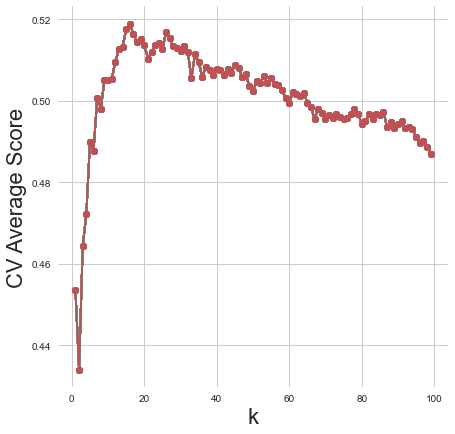

In [95]:
# Plot the graph of n_neighbor values and cv results (KNN Model)
plot_grid_search_knn(knn_gscv.cv_results_, np.arange(1, 100), 'k')

In [96]:
# KNN implementation example with the top performing n_neighbors value
knn = KNeighborsClassifier(n_neighbors=knn_gscv.best_params_.get('n_neighbors'))

# Training the classifier ; train_data.target will be having numbers assigned for each category in train data
clf = knn.fit(X_train_tfidf, train_data.target)

# Input Data to predict their classes of the given categories
# building up feature vector of the input
X_new_counts = count_vect.transform(test_data.data)

# I call transform instead of fit_transform because it's already been fit
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

In [97]:
# Create new a Naive Bayes model
naive_bayes_classifier2 = MultinomialNB()

# Create a dictionary of all values I want to test for fit_prior and alpha
param_grid = {'fit_prior': [True, False], 'alpha': [0.0, 1.0, 2.0, 3.0]}

# Use gridsearch to test all values for fit_prior and alpha
nbc_gscv = GridSearchCV(naive_bayes_classifier2, param_grid, cv=5)

# Fit model to data
nbc_gscv.fit(X_train_tfidf, train_data.target)

C:\Python39\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Python39\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Python39\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Python39\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Python39\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Python39\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Python39\lib\site-pac

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.0, 1.0, 2.0, 3.0],
                         'fit_prior': [True, False]})

In [98]:
# Check top performing fit_prior and alpha values
nbc_gscv.best_params_

{'alpha': 3.0, 'fit_prior': False}

In [99]:
# Check mean score for the top performing values of fit_prior and alpha
nbc_gscv.best_score_

0.5004839242378553

In [100]:
# Check results for each value of fit_prior and alpha
nbc_gscv.cv_results_

{'mean_fit_time': array([0.02255096, 0.02054458, 0.02475581, 0.02049365, 0.01882129,
        0.02632189, 0.02301111, 0.01914907]),
 'std_fit_time': array([0.00668855, 0.00173976, 0.00337967, 0.0018194 , 0.00043631,
        0.00559887, 0.00064786, 0.00097723]),
 'mean_score_time': array([0.00259352, 0.00299282, 0.00309591, 0.00260453, 0.00220976,
        0.00339122, 0.00319233, 0.0028326 ]),
 'std_score_time': array([4.87740994e-04, 3.16297988e-07, 4.81820800e-04, 7.90313269e-04,
        4.04287014e-04, 7.99859907e-04, 3.98802996e-04, 4.19709060e-04]),
 'param_alpha': masked_array(data=[0.0, 0.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_fit_prior': masked_array(data=[True, False, True, False, True, False, True, False],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'al

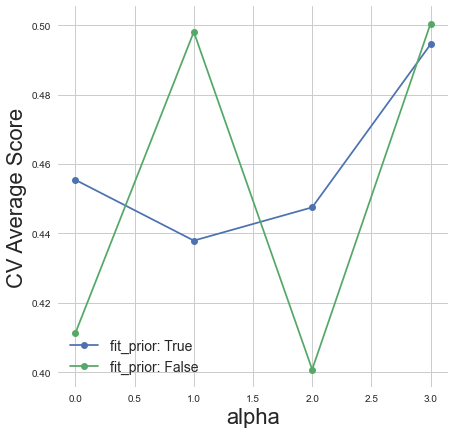

In [101]:
# Plot the graph of fit_prior and alpha values and cv results (Naive Bayes Model)
plot_grid_search_nb(nbc_gscv.cv_results_, [0.0, 1.0, 2.0, 3.0], [True, False], 'alpha', 'fit_prior')

In [102]:
# Naive bayes implementation
naive_bayes_classifier = MultinomialNB(fit_prior=nbc_gscv.best_params_.get('fit_prior'), alpha=nbc_gscv.best_params_.get('alpha'))
naive_bayes_classifier.fit(X_train_tfidf, train_data.target)

MultinomialNB(alpha=3.0, fit_prior=False)

In [103]:
# Naive Bayes 5-fold cross validation
# Train model with cv of 5 
cv_scores = cross_val_score(naive_bayes_classifier, X_train_tfidf, train_data.target, cv=5)

# Print each cv score (accuracy) and average them
print('Naive Bayes cv scores')
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

Naive Bayes cv scores
[0.51257485 0.46946108 0.5263789  0.49760192 0.49640288]
cv_scores mean:0.5004839242378553


C:\Python39\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [104]:
# Calculating predictions
knn_predicted = clf.predict(X_new_tfidf)
naive_bayes_predicted = naive_bayes_classifier.predict(X_new_tfidf)

# Compute the performance measures
knn_accuracy_score = metrics.accuracy_score(test_data.target, knn_predicted)
naive_bayes_accuracy_score = metrics.accuracy_score(test_data.target, naive_bayes_predicted)
    
print('KNN classification report over the movie test data by using multiple feature similarity:')
print("accuracy:   %0.3f" % knn_accuracy_score)
print(metrics.classification_report(test_data.target, knn_predicted))
print('Naive Bayes classification report over the movie test data by using multiple feature similarity:')
print("accuracy:   %0.3f" % naive_bayes_accuracy_score)
print(metrics.classification_report(test_data.target, naive_bayes_predicted))

KNN classification report over the movie test data by using multiple feature similarity:
accuracy:   0.479
              precision    recall  f1-score   support

           G       0.33      0.14      0.20         7
          PG       0.58      0.44      0.50        72
       PG-13       0.32      0.33      0.33        91
           R       0.43      0.53      0.48       165
       TV-14       0.48      0.60      0.53       221
        TV-G       0.00      0.00      0.00        18
       TV-MA       0.53      0.58      0.56       342
       TV-PG       0.43      0.13      0.20        90
        TV-Y       0.50      0.20      0.29        15
       TV-Y7       0.50      0.19      0.28        21
    TV-Y7-FV       0.00      0.00      0.00         2

    accuracy                           0.48      1044
   macro avg       0.37      0.29      0.31      1044
weighted avg       0.47      0.48      0.46      1044

Naive Bayes classification report over the movie test data by using multiple fea

C:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

In [105]:
# Example of predicting movie ratings by using movie description similarities

# Splitting movie dataset into 80% train data and 20% test data

X = movies['description']
y = movies['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

train_data.data = X_train
train_data.target = y_train
train_data.target_names = movie_rating_list

test_data.data = X_test
test_data.target = y_test

In [106]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train_data.data)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [107]:
# Create new a knn model
knn2 = KNeighborsClassifier()

# Create a dictionary of all values I want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 100)}

# Use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)

# Fit model to data
knn_gscv.fit(X_train_tfidf, train_data.target)

C:\Python39\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])})

In [108]:
# Check top performing n_neighbors value
knn_gscv.best_params_

{'n_neighbors': 69}

In [109]:
# Check mean score for the top performing value of n_neighbors
knn_gscv.best_score_

0.36145464466749955

In [110]:
# Check results for each value of n_neighbors
knn_gscv.cv_results_

{'mean_fit_time': array([0.00426836, 0.00437317, 0.00398846, 0.00400066, 0.00378551,
        0.00401888, 0.00398865, 0.0044435 , 0.00418825, 0.00517383,
        0.00367374, 0.00461383, 0.00463486, 0.00439377, 0.00397787,
        0.0033947 , 0.00519176, 0.004987  , 0.0034112 , 0.00379262,
        0.00401473, 0.00400205, 0.00478678, 0.00359492, 0.00378957,
        0.00378962, 0.00557795, 0.00400195, 0.00569429, 0.0041461 ,
        0.00438752, 0.00439277, 0.00465565, 0.00489573, 0.00405922,
        0.0037931 , 0.00369291, 0.00359035, 0.00400534, 0.00477257,
        0.0038229 , 0.00399799, 0.00419884, 0.00358768, 0.0037806 ,
        0.00359974, 0.00381145, 0.00379844, 0.00360355, 0.00398817,
        0.00514569, 0.00438113, 0.00364466, 0.00398359, 0.00358047,
        0.00439768, 0.00399423, 0.00358434, 0.0041111 , 0.00657606,
        0.00366879, 0.00438766, 0.00398927, 0.00339041, 0.00422401,
        0.0039959 , 0.00448847, 0.00379977, 0.00485787, 0.00378962,
        0.00380211, 0.00394859,

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


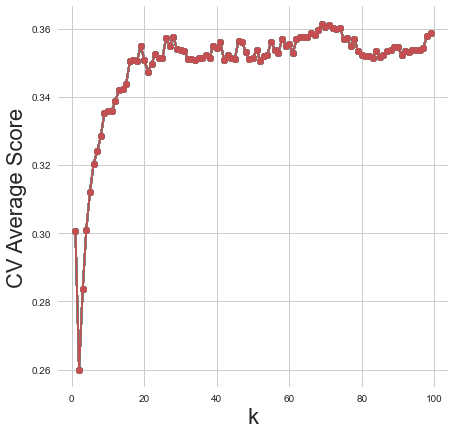

In [111]:
# Plot the graph of n_neighbor values and cv results (KNN Model)
plot_grid_search_knn(knn_gscv.cv_results_, np.arange(1, 100), 'k')

In [112]:
# KNN implementation example with the top performing n_neighbors value
knn = KNeighborsClassifier(n_neighbors=knn_gscv.best_params_.get('n_neighbors'))

# Training the classifier ; train_data.target will be having numbers assigned for each category in train data
clf = knn.fit(X_train_tfidf, train_data.target)

# Input Data to predict their classes of the given categories
# building up feature vector of the input
X_new_counts = count_vect.transform(test_data.data)

# I call transform instead of fit_transform because it's already been fit
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

In [113]:
# Create new a Naive Bayes model
naive_bayes_classifier2 = MultinomialNB()

# Create a dictionary of all values I want to test for fit_prior and alpha
param_grid = {'fit_prior': [True, False], 'alpha': [0.0, 1.0, 2.0, 3.0]}

# Use gridsearch to test all values for fit_prior and alpha
nbc_gscv = GridSearchCV(naive_bayes_classifier2, param_grid, cv=5)

# Fit model to data
nbc_gscv.fit(X_train_tfidf, train_data.target)

C:\Python39\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
C:\Python39\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Python39\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Python39\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Python39\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Python39\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Python39\lib\site-pac

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.0, 1.0, 2.0, 3.0],
                         'fit_prior': [True, False]})

In [114]:
# Check top performing fit_prior and alpha values
nbc_gscv.best_params_

{'alpha': 1.0, 'fit_prior': False}

In [115]:
# Check mean score for the top performing values of fit_prior and alpha
nbc_gscv.best_score_

0.3650483206249372

In [116]:
# Check results for each value of fit_prior and alpha
nbc_gscv.cv_results_

{'mean_fit_time': array([0.01754541, 0.01477723, 0.01356339, 0.01356306, 0.0137711 ,
        0.0149931 , 0.01476965, 0.01337414]),
 'std_fit_time': array([0.00276435, 0.00313745, 0.00048891, 0.00048883, 0.00076039,
        0.00090634, 0.00074028, 0.00049243]),
 'mean_score_time': array([0.0024014 , 0.00139165, 0.00179625, 0.0017961 , 0.00159683,
        0.0021853 , 0.00199051, 0.00159612]),
 'std_score_time': array([4.96377757e-04, 4.81696451e-04, 3.99112844e-04, 3.98445672e-04,
        4.88928151e-04, 4.03011511e-04, 1.06125999e-05, 4.87694877e-04]),
 'param_alpha': masked_array(data=[0.0, 0.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_fit_prior': masked_array(data=[True, False, True, False, True, False, True, False],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'al

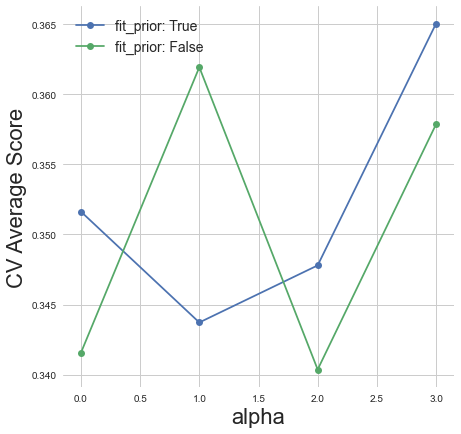

In [117]:
# Plot the graph of fit_prior and alpha values and cv results (Naive Bayes Model)
plot_grid_search_nb(nbc_gscv.cv_results_, [0.0, 1.0, 2.0, 3.0], [True, False], 'alpha', 'fit_prior')

In [118]:
# Naive bayes implementation
naive_bayes_classifier = MultinomialNB(fit_prior=nbc_gscv.best_params_.get('fit_prior'), alpha=nbc_gscv.best_params_.get('alpha'))
naive_bayes_classifier.fit(X_train_tfidf, train_data.target)

MultinomialNB(fit_prior=False)

In [119]:
#Naive Bayes 5-fold cross validation
# Train model with cv of 5 
cv_scores = cross_val_score(naive_bayes_classifier, X_train_tfidf, train_data.target, cv=5)

# Print each cv score (accuracy) and average them
print('Naive Bayes cv scores')
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

Naive Bayes cv scores
[0.3748503  0.37365269 0.36810552 0.34652278 0.36211031]
cv_scores mean:0.3650483206249372


C:\Python39\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


In [120]:
# Calculating predictions
knn_predicted = clf.predict(X_new_tfidf)
naive_bayes_predicted = naive_bayes_classifier.predict(X_new_tfidf)

# Compute the performance measures
knn_accuracy_score = metrics.accuracy_score(test_data.target, knn_predicted)
naive_bayes_accuracy_score = metrics.accuracy_score(test_data.target, naive_bayes_predicted)
    
print('KNN classification report over the movie test data by using description similarity:')
print("accuracy:   %0.3f" % knn_accuracy_score)
print(metrics.classification_report(test_data.target, knn_predicted))
print('Naive Bayes classification report over the movie test data by using description similarity:')
print("accuracy:   %0.3f" % naive_bayes_accuracy_score)
print(metrics.classification_report(test_data.target, naive_bayes_predicted))

KNN classification report over the movie test data by using description similarity:
accuracy:   0.368
              precision    recall  f1-score   support

           G       0.00      0.00      0.00         8
       NC-17       0.00      0.00      0.00         1
          PG       0.00      0.00      0.00        58
       PG-13       0.00      0.00      0.00        86
           R       0.38      0.06      0.10       161
       TV-14       0.33      0.35      0.34       238
        TV-G       0.00      0.00      0.00        14
       TV-MA       0.38      0.81      0.52       360
       TV-PG       0.00      0.00      0.00        92
        TV-Y       1.00      0.08      0.15        12
       TV-Y7       0.00      0.00      0.00        14

    accuracy                           0.37      1044
   macro avg       0.19      0.12      0.10      1044
weighted avg       0.28      0.37      0.27      1044

Naive Bayes classification report over the movie test data by using description simil

C:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

In [121]:
# Example of predicting tv show ratings by using multiple tv show feature similarities

# Splitting tv show dataset into 80% train data and 20% test data

X = tv_shows['all_content']
y = tv_shows['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

train_data.data = X_train
train_data.target = y_train
train_data.target_names = movie_rating_list

test_data.data = X_test
test_data.target = y_test

In [122]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train_data.data)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [123]:
# Create new a knn model
knn2 = KNeighborsClassifier()

# Create a dictionary of all values I want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 100)}

# Use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)

# Fit model to data
knn_gscv.fit(X_train_tfidf, train_data.target)

C:\Python39\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])})

In [124]:
# Check top performing n_neighbors value
knn_gscv.best_params_

{'n_neighbors': 30}

In [125]:
# Check mean score for the top performing value of n_neighbors
knn_gscv.best_score_

0.5065073168855643

In [126]:
# Check results for each value of n_neighbors
knn_gscv.cv_results_

{'mean_fit_time': array([0.00379758, 0.0023921 , 0.00266356, 0.00239329, 0.002001  ,
        0.00259438, 0.00190988, 0.00239997, 0.00219469, 0.00260329,
        0.00240469, 0.00279388, 0.00199418, 0.00199389, 0.00200233,
        0.00201287, 0.0019978 , 0.00221987, 0.00281339, 0.00280237,
        0.00221386, 0.00200219, 0.00218825, 0.00220752, 0.00199528,
        0.00210571, 0.00200038, 0.00260091, 0.00279341, 0.00200853,
        0.00240812, 0.00199566, 0.00219383, 0.00199451, 0.00239325,
        0.00239501, 0.00180049, 0.00210834, 0.00220709, 0.00199471,
        0.00199494, 0.00219417, 0.00201125, 0.00219393, 0.00259748,
        0.0022016 , 0.00220509, 0.00199528, 0.00260725, 0.00200438,
        0.00232072, 0.00190883, 0.00220423, 0.00239363, 0.00199575,
        0.00218725, 0.00218477, 0.00239425, 0.0022121 , 0.00203729,
        0.00222507, 0.00204329, 0.00221477, 0.00200768, 0.00203419,
        0.00200219, 0.00199618, 0.00218859, 0.00238752, 0.00214858,
        0.00241966, 0.00199413,

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


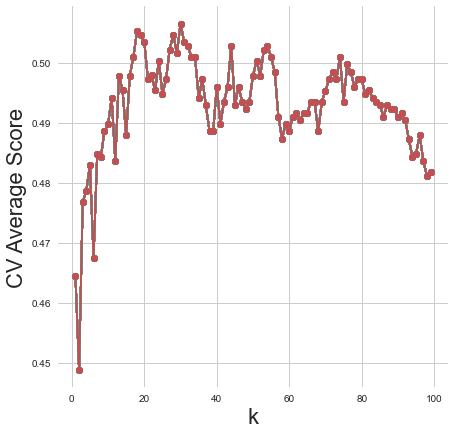

In [127]:
# Plot the graph of n_neighbor values and cv results (KNN Model)
plot_grid_search_knn(knn_gscv.cv_results_, np.arange(1, 100), 'k')

In [128]:
# KNN implementation example with the top performing n_neighbors value
knn = KNeighborsClassifier(n_neighbors=knn_gscv.best_params_.get('n_neighbors'))

# Training the classifier ; train_data.target will be having numbers assigned for each category in train data
clf = knn.fit(X_train_tfidf, train_data.target)

# Input Data to predict their classes of the given categories
# building up feature vector of the input
X_new_counts = count_vect.transform(test_data.data)

# I call transform instead of fit_transform because it's already been fit
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

In [129]:
# Create new a Naive Bayes model
naive_bayes_classifier2 = MultinomialNB()

# Create a dictionary of all values I want to test for fit_prior and alpha
param_grid = {'fit_prior': [True, False], 'alpha': [0.0, 1.0, 2.0, 3.0]}

# Use gridsearch to test all values for fit_prior and alpha
nbc_gscv = GridSearchCV(naive_bayes_classifier2, param_grid, cv=5)

# Fit model to data
nbc_gscv.fit(X_train_tfidf, train_data.target)

C:\Python39\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Python39\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Python39\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Python39\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Python39\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Python39\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Python39\lib\site-pac

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.0, 1.0, 2.0, 3.0],
                         'fit_prior': [True, False]})

In [130]:
# Check top performing fit_prior and alpha values
nbc_gscv.best_params_

{'alpha': 1.0, 'fit_prior': False}

In [131]:
# Check mean score for the top performing values of fit_prior and alpha
nbc_gscv.best_score_

0.5238678537776666

In [132]:
# Check results for each value of fit_prior and alpha
nbc_gscv.cv_results_

{'mean_fit_time': array([0.01077108, 0.00658164, 0.00629163, 0.00618262, 0.00618305,
        0.00598345, 0.00657024, 0.00837712]),
 'std_fit_time': array([0.00291939, 0.00101739, 0.00058576, 0.00039926, 0.00074555,
        0.00089228, 0.00047991, 0.00119617]),
 'mean_score_time': array([0.00139661, 0.00119743, 0.00119677, 0.00119743, 0.00119772,
        0.00100961, 0.00120821, 0.00099916]),
 'std_score_time': array([4.88266288e-04, 3.99185491e-04, 3.99880019e-04, 3.99184352e-04,
        4.00233961e-04, 2.42595327e-05, 4.19783629e-04, 5.51978917e-07]),
 'param_alpha': masked_array(data=[0.0, 0.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_fit_prior': masked_array(data=[True, False, True, False, True, False, True, False],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'al

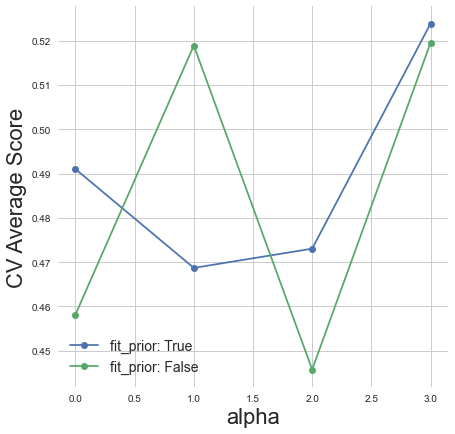

In [133]:
# Plot the graph of fit_prior and alpha values and cv results (Naive Bayes Model)
plot_grid_search_nb(nbc_gscv.cv_results_, [0.0, 1.0, 2.0, 3.0], [True, False], 'alpha', 'fit_prior')

In [134]:
# Naive bayes implementation
naive_bayes_classifier = MultinomialNB(fit_prior=nbc_gscv.best_params_.get('fit_prior'), alpha=nbc_gscv.best_params_.get('alpha'))
naive_bayes_classifier.fit(X_train_tfidf, train_data.target)

MultinomialNB(fit_prior=False)

In [135]:
#Naive Bayes 5-fold cross validation
# Train model with cv of 5 
cv_scores = cross_val_score(naive_bayes_classifier, X_train_tfidf, train_data.target, cv=5)

# Print each cv score (accuracy) and average them
print('Naive Bayes cv scores')
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

Naive Bayes cv scores
[0.54179567 0.52012384 0.51083591 0.5621118  0.48447205]
cv_scores mean:0.5238678537776666


C:\Python39\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [136]:
# Calculating predictions
knn_predicted = clf.predict(X_new_tfidf)
naive_bayes_predicted = naive_bayes_classifier.predict(X_new_tfidf)

# Compute the performance measures
knn_accuracy_score = metrics.accuracy_score(test_data.target, knn_predicted)
naive_bayes_accuracy_score = metrics.accuracy_score(test_data.target, naive_bayes_predicted)
    
print('KNN classification report over the tv show test data by using multiple feature similarity:')
print("accuracy:   %0.3f" % knn_accuracy_score)
print(metrics.classification_report(test_data.target, knn_predicted))
print('Naive Bayes classification report over the tv show test data by using multiple feature similarity:')
print("accuracy:   %0.3f" % naive_bayes_accuracy_score)
print(metrics.classification_report(test_data.target, naive_bayes_predicted))

C:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

KNN classification report over the tv show test data by using multiple feature similarity:
accuracy:   0.525
              precision    recall  f1-score   support

       TV-14       0.50      0.54      0.52       119
        TV-G       0.00      0.00      0.00        13
       TV-MA       0.56      0.73      0.64       173
       TV-PG       0.28      0.21      0.24        38
        TV-Y       0.60      0.25      0.35        24
       TV-Y7       0.70      0.19      0.30        37

    accuracy                           0.52       404
   macro avg       0.44      0.32      0.34       404
weighted avg       0.51      0.52      0.50       404

Naive Bayes classification report over the tv show test data by using multiple feature similarity:
accuracy:   0.537
              precision    recall  f1-score   support

       TV-14       0.56      0.53      0.54       119
        TV-G       0.00      0.00      0.00        13
       TV-MA       0.56      0.80      0.66       173
       TV-PG  

C:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [137]:
# Example of predicting tv show ratings by using tv show description similarities

# Splitting tv show dataset into 80% train data and 20% test data

X = tv_shows['description']
y = tv_shows['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

train_data.data = X_train
train_data.target = y_train
train_data.target_names = tv_show_rating_list

test_data.data = X_test
test_data.target = y_test

In [138]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train_data.data)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [139]:
# Create new a knn model
knn2 = KNeighborsClassifier()

# Create a dictionary of all values I want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 100)}

# Use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn2, param_grid, cv=5)

# Fit model to data
knn_gscv.fit(X_train_tfidf, train_data.target)

C:\Python39\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])})

In [140]:
# Check top performing n_neighbors value
knn_gscv.best_params_

{'n_neighbors': 28}

In [141]:
# Check mean score for the top performing value of n_neighbors
knn_gscv.best_score_

0.5021767974924524

In [142]:
# Check results for each value of n_neighbors
knn_gscv.cv_results_

{'mean_fit_time': array([0.00239778, 0.00199494, 0.00199509, 0.00199456, 0.00217705,
        0.00200496, 0.00200524, 0.00219531, 0.00201435, 0.00239162,
        0.00199537, 0.00211492, 0.00199504, 0.0021945 , 0.00200477,
        0.00181651, 0.00201488, 0.00239906, 0.00199485, 0.00219936,
        0.00198545, 0.00239849, 0.00180759, 0.00200529, 0.00219913,
        0.00201244, 0.0020155 , 0.00257039, 0.00200548, 0.00200577,
        0.00200567, 0.00239525, 0.00201526, 0.00179577, 0.00210443,
        0.0023047 , 0.00200071, 0.00199456, 0.00200572, 0.00199461,
        0.00199432, 0.0019959 , 0.0019855 , 0.00200496, 0.00196981,
        0.00238352, 0.00259323, 0.00219531, 0.00200195, 0.00318508,
        0.00200505, 0.0023273 , 0.00219517, 0.00272584, 0.00259295,
        0.00219865, 0.00198731, 0.00199471, 0.00221419, 0.00199533,
        0.00240459, 0.00199742, 0.00201473, 0.00190444, 0.00173168,
        0.00201688, 0.00198584, 0.00220037, 0.00218706, 0.00198879,
        0.00227203, 0.00267773,

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


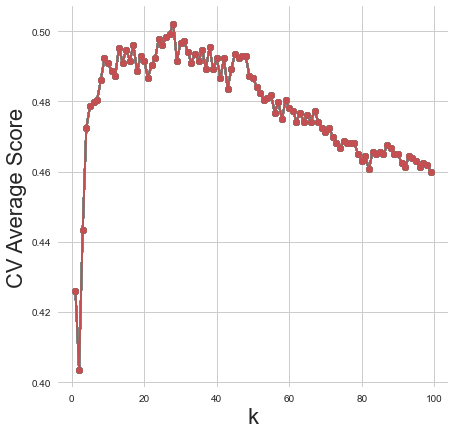

In [143]:
# Plot the graph of n_neighbor values and cv results (KNN Model)
plot_grid_search_knn(knn_gscv.cv_results_, np.arange(1, 100), 'k')

In [144]:
# KNN implementation example with the top performing n_neighbors value
knn = KNeighborsClassifier(n_neighbors=knn_gscv.best_params_.get('n_neighbors'))

# Training the classifier ; train_data.target will be having numbers assigned for each category in train data
clf = knn.fit(X_train_tfidf, train_data.target)

# Input Data to predict their classes of the given categories
# building up feature vector of the input
X_new_counts = count_vect.transform(test_data.data)

# I call transform instead of fit_transform because it's already been fit
X_new_tfidf = tfidf_transformer.transform(X_new_counts)

In [145]:
# Create new a Naive Bayes model
naive_bayes_classifier2 = MultinomialNB()

# Create a dictionary of all values I want to test for fit_prior and alpha
param_grid = {'fit_prior': [True, False], 'alpha': [0.0, 1.0, 2.0, 3.0]}

# Use gridsearch to test all values for fit_prior and alpha
nbc_gscv = GridSearchCV(naive_bayes_classifier2, param_grid, cv=5)

# Fit model to data
nbc_gscv.fit(X_train_tfidf, train_data.target)

C:\Python39\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Python39\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Python39\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Python39\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Python39\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Python39\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Python39\lib\site-pac

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.0, 1.0, 2.0, 3.0],
                         'fit_prior': [True, False]})

In [146]:
# Check top performing fit_prior and alpha values
nbc_gscv.best_params_

{'alpha': 2.0, 'fit_prior': False}

In [147]:
# Check mean score for the top performing values of fit_prior and alpha
nbc_gscv.best_score_

0.5108801415302964

In [148]:
# Check results for each value of fit_prior and alpha
nbc_gscv.cv_results_

{'mean_fit_time': array([0.00937557, 0.00582561, 0.00508938, 0.00498624, 0.00498619,
        0.00558419, 0.00518575, 0.00479798]),
 'std_fit_time': array([7.97869162e-04, 1.57482800e-03, 2.02974495e-04, 4.37028474e-07,
        6.30752500e-04, 4.89552884e-04, 9.77788057e-04, 7.49958280e-04]),
 'mean_score_time': array([0.00119658, 0.00056701, 0.00090861, 0.00059834, 0.0005991 ,
        0.00019994, 0.00059867, 0.00039916]),
 'std_score_time': array([0.00039926, 0.00046414, 0.00017762, 0.00048854, 0.00048916,
        0.00039988, 0.00048881, 0.00048887]),
 'param_alpha': masked_array(data=[0.0, 0.0, 1.0, 1.0, 2.0, 2.0, 3.0, 3.0],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_fit_prior': masked_array(data=[True, False, True, False, True, False, True, False],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'al

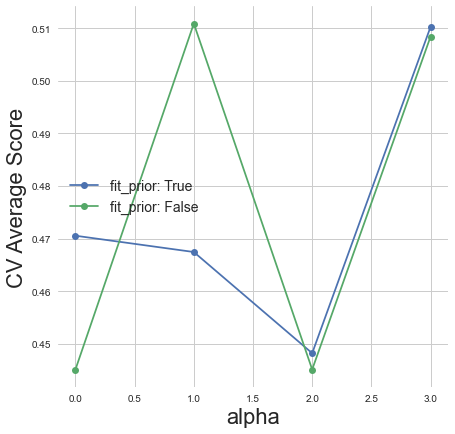

In [149]:
# Plot the graph of fit_prior and alpha values and cv results (Naive Bayes Model)
plot_grid_search_nb(nbc_gscv.cv_results_, [0.0, 1.0, 2.0, 3.0], [True, False], 'alpha', 'fit_prior')

In [150]:
# Naive bayes implementation
naive_bayes_classifier = MultinomialNB(fit_prior=nbc_gscv.best_params_.get('fit_prior'), alpha=nbc_gscv.best_params_.get('alpha'))
naive_bayes_classifier.fit(X_train_tfidf, train_data.target)

MultinomialNB(alpha=2.0, fit_prior=False)

In [151]:
# Naive Bayes 5-fold cross validation
# Train model with cv of 5 
cv_scores = cross_val_score(naive_bayes_classifier, X_train_tfidf, train_data.target, cv=5)

# Print each cv score (accuracy) and average them
print('Naive Bayes cv scores')
print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

Naive Bayes cv scores
[0.47368421 0.49226006 0.51702786 0.54037267 0.5310559 ]
cv_scores mean:0.5108801415302964


C:\Python39\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [152]:
# Calculating predictions
knn_predicted = clf.predict(X_new_tfidf)
naive_bayes_predicted = naive_bayes_classifier.predict(X_new_tfidf)

# Compute the performance measures
knn_accuracy_score = metrics.accuracy_score(test_data.target, knn_predicted)
naive_bayes_accuracy_score = metrics.accuracy_score(test_data.target, naive_bayes_predicted)
    
print('KNN classification report over the tv show test data by using description similarity:')
print("accuracy:   %0.3f" % knn_accuracy_score)
print(metrics.classification_report(test_data.target, knn_predicted))
print('Naive Bayes classification report over the tv show test data by using description similarity:')
print("accuracy:   %0.3f" % naive_bayes_accuracy_score)
print(metrics.classification_report(test_data.target, naive_bayes_predicted))

KNN classification report over the tv show test data by using description similarity:
accuracy:   0.463
              precision    recall  f1-score   support

       TV-14       0.43      0.27      0.33       127
        TV-G       0.00      0.00      0.00        14
       TV-MA       0.46      0.86      0.60       165
       TV-PG       0.00      0.00      0.00        40
        TV-Y       0.64      0.35      0.45        26
       TV-Y7       0.67      0.06      0.11        32

    accuracy                           0.46       404
   macro avg       0.37      0.26      0.25       404
weighted avg       0.42      0.46      0.39       404

Naive Bayes classification report over the tv show test data by using description similarity:
accuracy:   0.455
              precision    recall  f1-score   support

       TV-14       0.38      0.14      0.21       127
        TV-G       0.00      0.00      0.00        14
       TV-MA       0.45      0.91      0.61       165
       TV-PG       0.43 

C:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Python39\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
